<a href="https://colab.research.google.com/github/jrogan5/ECSE415_Assignment4/blob/main/AS4_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECSE 415 Assignment 4 - Traffic Sign Detection (Kaggle Version)

This notebook has been adapted to run in Kaggle with GPU support.

## Setup Instructions for Kaggle:

1. **Add Dataset**: Add your "Road_Signs_Detection_Dataset" as a dataset to this notebook
2. **Update Dataset Path**: In the first code cell, update `BASE_PATH` to match your dataset name
3. **Enable GPU**: Settings → Accelerator → GPU (T4 or P100)
4. **Internet**: Enable if you need to download pretrained models (Settings → Internet → On)

## What this notebook does:

- Trains **YOLOv8** baseline model for traffic sign detection
- Trains improved **RetinaNet** models (v1 and v2)
- Generates multiple submission files with different confidence thresholds
- Evaluates models with mAP, F1 score, and confusion matrices


In [ ]:
# ================================
# Kaggle Environment Setup
# ================================
import os
from pathlib import Path

# Detect if we're running in Kaggle
IS_KAGGLE = os.path.exists('/kaggle')

if IS_KAGGLE:
    print("Running in Kaggle environment")
    # Note: Update 'road-signs-detection' with your actual Kaggle dataset name
    # You can find this in the dataset URL or when you add data to your notebook
    BASE_PATH = Path("/kaggle/input/road-signs-detection")
    OUTPUT_PATH = Path("/kaggle/working")
    
    # Verify the dataset exists
    if not BASE_PATH.exists():
        print(f"WARNING: Dataset not found at {BASE_PATH}")
        print("Available input datasets:")
        if Path("/kaggle/input").exists():
            for item in Path("/kaggle/input").iterdir():
                print(f"  - {item.name}")
        print("\nPlease update the BASE_PATH variable to match your dataset name.")
else:
    print("Running in local/Colab environment")
    # For local development - update this path as needed
    BASE_PATH = Path("./")
    OUTPUT_PATH = Path("./")

print(f"Base path: {BASE_PATH}")
print(f"Output path: {OUTPUT_PATH}")


In [ ]:
# ================================
# GPU Availability Check
# ================================
import torch

if torch.cuda.is_available():
    print(f"✓ GPU is available!")
    print(f"  Device name: {torch.cuda.get_device_name(0)}")
    print(f"  Device count: {torch.cuda.device_count()}")
    print(f"  Current device: {torch.cuda.current_device()}")
    print(f"  Memory allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"  Memory cached: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
else:
    print("⚠ GPU is NOT available. Training will be slow.")
    print("  In Kaggle: Go to Settings > Accelerator > Select 'GPU'")
    print("  Then restart the notebook session.")


In [1]:

import cv2
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import torch

from pathlib import Path
import sklearn
import skimage
from skimage import __version__ as skimage_version
from sklearn import __version__ as sklearn_version


path = str(BASE_PATH)  # Set by environment detection cell above

print(f"Python version:           {os.sys.version.split()[0]}")
print(f"OpenCV version:           {cv2.__version__}")
print(f"NumPy version:            {np.__version__}")
print(f"Matplotlib version:       {matplotlib.__version__}")
print(f"PyTorch version:          {torch.__version__}")
print(f"scikit-image version:     {skimage_version}")
print(f"scikit-learn version:     {sklearn_version}")
print("Path: " + path)

# Display sanity helpers
from IPython import get_ipython
ip = get_ipython()
if ip: ip.run_line_magic("matplotlib", "inline")

import matplotlib, matplotlib.pyplot as plt, numpy as np, cv2

# Make inline figures a bit sharper
matplotlib.rcParams["figure.dpi"] = 120

print("Matplotlib backend:", matplotlib.get_backend())

# Preprocessing configuration
RESIZE_ENABLED = True
TARGET_SIZE = 256

# Normalize [0,1] or [-1,1]
NORMALIZE_TO_MINUS1_1 = False





Python version:           3.12.12
OpenCV version:           4.12.0
NumPy version:            2.0.2
Matplotlib version:       3.10.0
PyTorch version:          2.8.0+cu126
scikit-image version:     0.25.2
scikit-learn version:     1.6.1
Path: C:\Users\jrog1\OneDrive\Desktop\Semester 5\ECSE415\ECSE415_Assignment4\
Matplotlib backend: module://matplotlib_inline.backend_inline


In [2]:
# ================================
# Paths and class names
# ================================
root = Path(path, "Road_Signs_Detection_Dataset")

TRAIN_IMAGES = Path(root, "train", "images")
TRAIN_LABELS = Path(root, "train", "labels")
TEST_IMAGES  = Path(root, "test", "images")

print("Train images dir :", TRAIN_IMAGES)
print("Train labels dir :", TRAIN_LABELS)
print("Test images dir  :", TEST_IMAGES)

print("Num train images :", len(list(TRAIN_IMAGES.glob("*.jpg"))))
print("Num train labels :", len(list(TRAIN_LABELS.glob("*.txt"))))
print("Num test images  :", len(list(TEST_IMAGES.glob("*.jpg"))))

class_names = [
    "Speed Limit 80",   # 0
    "Speed Limit 50",   # 1
    "Green Light",      # 2
    "Speed Limit 90",   # 3
    "Speed Limit 40",   # 4
    "Speed Limit 120",  # 5
    "Stop",             # 6
    "Speed Limit 60",   # 7
    "Speed Limit 70",   # 8
    "Speed Limit 20",   # 9
    "Speed Limit 110",  # 10
    "Red Light",        # 11
    "Speed Limit 30",   # 12
    "Speed Limit 100"   # 13
]
num_classes = len(class_names)
print("Number of classes:", num_classes)

Train images dir : C:\Users\jrog1\OneDrive\Desktop\Semester 5\ECSE415\ECSE415_Assignment4\/Road_Signs_Detection_Dataset/train/images
Train labels dir : C:\Users\jrog1\OneDrive\Desktop\Semester 5\ECSE415\ECSE415_Assignment4\/Road_Signs_Detection_Dataset/train/labels
Test images dir  : C:\Users\jrog1\OneDrive\Desktop\Semester 5\ECSE415\ECSE415_Assignment4\/Road_Signs_Detection_Dataset/test/images
Num train images : 0
Num train labels : 0
Num test images  : 0
Number of classes: 14


In [3]:
# ================================
# Helper: load YOLO-format labels
# ================================
def load_yolo_labels(label_path: Path):
    """
    Load YOLO-format labels from a .txt file.
    Each line: <class_id> <x_center> <y_center> <width> <height> (normalized)
    """
    boxes = []
    if not label_path.exists():
        return boxes

    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls = int(parts[0])
            xc, yc, w, h = map(float, parts[1:])
            boxes.append((cls, xc, yc, w, h))
    return boxes


In [4]:
# ================================
# Show sample images with bounding boxes and labels
# ================================
import random

def show_samples_with_boxes(n_samples=8):
    image_files = list(TRAIN_IMAGES.glob("*.jpg"))
    if len(image_files) == 0:
        print("No images found in", TRAIN_IMAGES)
        return

    random.shuffle(image_files)
    image_files = image_files[:n_samples]

    rows = 2
    cols = (n_samples + 1) // 2

    plt.figure(figsize=(4 * cols, 4 * rows))

    for i, img_path in enumerate(image_files):
        label_path = Path(TRAIN_LABELS, img_path.stem + ".txt")

        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        boxes = load_yolo_labels(label_path)

        # draw bounding boxes
        for (cls, xc, yc, bw, bh) in boxes:
            xc_pix = xc * w
            yc_pix = yc * h
            bw_pix = bw * w
            bh_pix = bh * h

            x1 = int(xc_pix - bw_pix / 2)
            y1 = int(yc_pix - bh_pix / 2)
            x2 = int(xc_pix + bw_pix / 2)
            y2 = int(yc_pix + bh_pix / 2)

            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            label_text = f"{cls}: {class_names[cls]}"
            cv2.putText(img, label_text, (x1, max(0, y1 - 5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(img_path.name)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Call the function to visualize samples
show_samples_with_boxes(n_samples=8)   #

No images found in C:\Users\jrog1\OneDrive\Desktop\Semester 5\ECSE415\ECSE415_Assignment4\/Road_Signs_Detection_Dataset/train/images


Instances per class: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


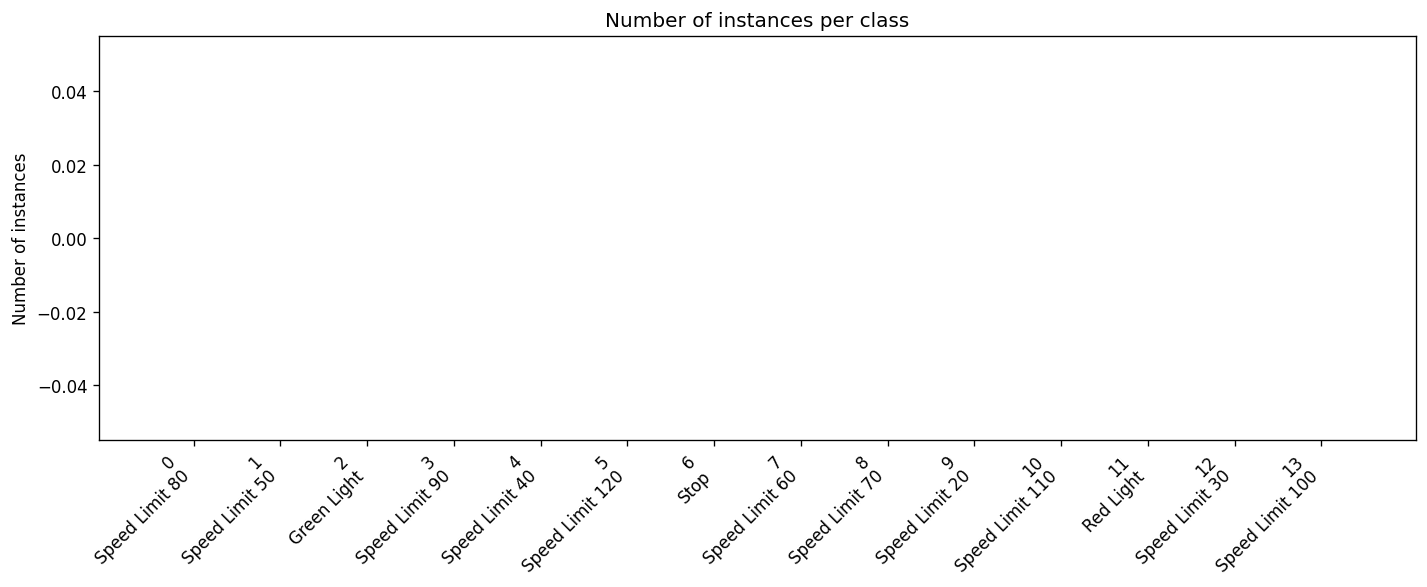

In [5]:
# ================================
# Count number of instances per class
# ================================
from collections import Counter

def count_instances_per_class():
    counts = Counter()
    label_files = list(TRAIN_LABELS.glob("*.txt"))
    for lf in label_files:
        with open(lf, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    cls = int(parts[0])
                    counts[cls] += 1
    # Convert to list ordered by class index
    class_counts = [counts[i] for i in range(num_classes)]
    return class_counts

class_counts = count_instances_per_class()
print("Instances per class:", class_counts)

# ================================
# Plot bar chart of instances per class
# ================================
x = np.arange(num_classes)

plt.figure(figsize=(12, 5))
plt.bar(x, class_counts)
plt.xticks(
    x,
    [f"{i}\n{class_names[i]}" for i in range(num_classes)],
    rotation=45,
    ha="right"
)
plt.ylabel("Number of instances")
plt.title("Number of instances per class")
plt.tight_layout()
plt.show()



In [6]:
# ================================
# Image Preprocessing Configuration
# ================================
# Whether to resize images, and the target resolution.
RESIZE_ENABLED = True
TARGET_SIZE = 256   # e.g., 256; can also be 128 or kept as 416

# Pixel normalization range: [0,1] or [-1,1]
NORMALIZE_TO_MINUS1_1 = False  # Set True to normalize to [-1,1]


# ================================
# Image Loading & Preprocessing Function
# ================================
def load_and_preprocess_image(img_path, resize=RESIZE_ENABLED, target_size=TARGET_SIZE,
                              normalize_to_minus1_1=NORMALIZE_TO_MINUS1_1):
    """
    Load an image and apply the following preprocessing steps:
    1) Convert from BGR (OpenCV default) to RGB
    2) Optionally resize to target_size x target_size
    3) Convert to float32
    4) Normalize pixel values either to [0,1] or [-1,1]

    Returns:
        Preprocessed image as a (H, W, 3) float32 numpy array
    """
    img = cv2.imread(str(img_path))
    if img is None:
        raise ValueError(f"Failed to load image: {img_path}")

    # Convert BGR to RGB (required for visualization and consistency)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Optional resizing (dataset is originally 416x416; resizing reduces computation)
    if resize:
        img = cv2.resize(img, (target_size, target_size), interpolation=cv2.INTER_LINEAR)

    # Convert to float32
    img = img.astype(np.float32)

    # Normalize pixel values to [0,1]
    img = img / 255.0

    # normalize further to [-1,1],But i will use[0,1]
    if normalize_to_minus1_1:
        img = img * 2.0 - 1.0

    return img


# ================================
# Build Dataset Lists for Train/Val Split
# ================================
all_image_paths = sorted(TRAIN_IMAGES.glob("*.jpg"))

image_paths_for_split = []
label_paths_for_split = []
rep_classes = []   # Representative class per image for stratified splitting

for img_path in all_image_paths:
    label_path = Path(TRAIN_LABELS, img_path.stem + ".txt")
    boxes = load_yolo_labels(label_path)

    # If an image has no annotations, skip it
    if len(boxes) == 0:
        continue

    # Use the class_id of the first object as the representative class
    rep_class = boxes[0][0]

    image_paths_for_split.append(img_path)
    label_paths_for_split.append(label_path)
    rep_classes.append(rep_class)

print("Number of images used for train/val split:", len(image_paths_for_split))
print("Example representative classes:", rep_classes[:10])


# ================================
# Train/Validation Split (70/30 with stratification)
# ================================
from sklearn.model_selection import train_test_split

train_imgs, val_imgs, train_labels, val_labels, y_train, y_val = train_test_split(
    image_paths_for_split,
    label_paths_for_split,
    rep_classes,
    test_size=0.3,          # 30% for validation
    random_state=42,        # Ensure reproducibility
    stratify=rep_classes    # Stratified split to preserve class distribution
)

print("Train size:", len(train_imgs))
print("Val size  :", len(val_imgs))


# ================================
# Check Class Distribution in Train/Val
# ================================
from collections import Counter

train_class_dist = Counter(y_train)
val_class_dist   = Counter(y_val)

def pretty_print_class_dist(counter, name):
    """
    Print class distribution with class IDs and names for readability.
    """
    print(f"\n{name} class distribution:")
    for cls_id in range(num_classes):
        count = counter.get(cls_id, 0)
        print(f"  Class {cls_id:2d} ({class_names[cls_id]:>15}): {count}")

pretty_print_class_dist(train_class_dist, "Train")
pretty_print_class_dist(val_class_dist, "Validation")

Number of images used for train/val split: 0
Example representative classes: []


ValueError: With n_samples=0, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
# ================================
# 2.1 Baseline Object Recognition with YOLOv8 (FIXED YAML)
# ================================
# This cell:
#   1) Prepares a YOLO-style train/val split using the lists train_imgs / val_imgs
#   2) Creates a dataset YAML file (using a safer list format for 'names')
#   3) Fine-tunes a pretrained YOLOv8 model
#   4) Evaluates it on the validation set and prints key metrics

!pip install -q ultralytics

import os
import shutil
from ultralytics import YOLO

# -----------------------------------
# Auto-detect GPU availability for YOLO
# -----------------------------------
import torch
cuda_available = torch.cuda.is_available()
yolo_device = 0 if cuda_available else 'cpu'

print("=" * 70)
print(f"YOLO Training Device: {yolo_device}")
if not cuda_available:
    print("⚠️  No GPU detected. Training on CPU (slower but works)")
print("=" * 70)

# -----------------------------------
# 1) Prepare YOLO train/val folder structure using our split
# -----------------------------------
# We reuse the 'root', 'train_imgs', 'val_imgs', 'train_labels', 'val_labels'
# defined in previous cells.

yolo_root = Path(OUTPUT_PATH, "yolo_split")
train_img_dir = Path(yolo_root, "train", "images")
train_lbl_dir = Path(yolo_root, "train", "labels")
val_img_dir   = Path(yolo_root, "val", "images")
val_lbl_dir   = Path(yolo_root, "val", "labels")

# Create directories
for d in [train_img_dir, train_lbl_dir, val_img_dir, val_lbl_dir]:
    d.mkdir(parents=True, exist_ok=True)

def link_or_copy(src, dst):
    """
    Try to create a symlink; if not allowed (e.g., on some systems),
    fall back to copying the file.
    """
    dst.parent.mkdir(parents=True, exist_ok=True)
    if dst.exists():
        return
    try:
        os.symlink(src, dst)
    except OSError:
        shutil.copy2(src, dst)

# Populate YOLO train split
for img_p, lbl_p in zip(train_imgs, train_labels):
    link_or_copy(img_p, Path(train_img_dir, img_p.name))
    link_or_copy(lbl_p, Path(train_lbl_dir, lbl_p.name))

# Populate YOLO val split
for img_p, lbl_p in zip(val_imgs, val_labels):
    link_or_copy(img_p, Path(val_img_dir, img_p.name))
    link_or_copy(lbl_p, Path(val_lbl_dir, lbl_p.name))

print("YOLO train images:", len(list(train_img_dir.glob("*.jpg"))))
print("YOLO val images  :", len(list(val_img_dir.glob("*.jpg"))))

# -----------------------------------
# 2) Create dataset YAML for YOLOv8 (use list format for 'names')
# -----------------------------------
dataset_yaml_path = Path(yolo_root, "traffic_signs_yolo.yaml")

dataset_yaml_text = f"""path: {yolo_root}
train: train/images
val: val/images

names:
  - Speed Limit 80
  - Speed Limit 50
  - Green Light
  - Speed Limit 90
  - Speed Limit 40
  - Speed Limit 120
  - Stop
  - Speed Limit 60
  - Speed Limit 70
  - Speed Limit 20
  - Speed Limit 110
  - Red Light
  - Speed Limit 30
  - Speed Limit 100
"""

with open(dataset_yaml_path, "w") as f:
    f.write(dataset_yaml_text)

print("Dataset YAML saved to:", dataset_yaml_path)

# -----------------------------------
# 3) Initialize and fine-tune YOLOv8 model
# -----------------------------------
model = YOLO("yolov8n.pt")  # nano model, pretrained on COCO

train_results = model.train(
    data=str(dataset_yaml_path),
    imgsz=416,
    epochs=30,                      # you can reduce to ~20 if time is tight
    batch=16,
    lr0=1e-3,
    device=yolo_device,             # Auto-detected: 0 for GPU, 'cpu' for CPU
        project=str(OUTPUT_PATH / "runs_yolov8_baseline"),
    name="yolov8n_traffic_signs",
    exist_ok=True
)

print("Training finished.")

# -----------------------------------
# 4) Evaluate the baseline model on the validation set
# -----------------------------------
val_metrics = model.val(
    data=str(dataset_yaml_path),
    imgsz=416,
    batch=16,
    device=yolo_device,             # Auto-detected: 0 for GPU, 'cpu' for CPU
        project=str(OUTPUT_PATH / "runs_yolov8_baseline"),
    name="yolov8n_traffic_signs_val",
    exist_ok=True
)

# Access main metrics from Ultralytics
mean_precision = val_metrics.box.mp
mean_recall    = val_metrics.box.mr
f1_score       = 2 * mean_precision * mean_recall / (mean_precision + mean_recall + 1e-16)

print("\n=== Baseline YOLOv8 Validation Metrics ===")
print(f"mAP@50-95 (all classes): {val_metrics.box.map:.4f}")
print(f"mAP@50    (all classes): {val_metrics.box.map50:.4f}")
print(f"Mean Precision        : {mean_precision:.4f}")
print(f"Mean Recall           : {mean_recall:.4f}")
print(f"F1 score (overall)    : {f1_score:.4f}")

print("\nPer-class AP (Ultralytics 'maps', typically AP@50-95 per class):")
for i, ap in enumerate(val_metrics.box.maps):
    print(f"  Class {i:2d} ({class_names[i]:>15}): {ap:.4f}")

cm_dir = Path(root, "runs_yolov8_baseline", "yolov8n_traffic_signs_val")
print("\nConfusion matrix and other plots are saved in:")
print(cm_dir)

In [ ]:
# ================================
# 2.2 Analysis of Baseline Results
# ================================
# This cell:
#   1) Visualizes YOLOv8 predictions on a subset of validation images
#   2) Displays the confusion matrix image saved by Ultralytics
#   3) (Optionally) prints again the main metrics if available

# -----------------------------------
# 1) Visualize predictions on validation images
# -----------------------------------
# We use the existing 'val_imgs' list and the trained 'model' from 2.1.

num_samples = 8  # number of validation images to visualize (5–10 is fine)
sample_val_imgs = val_imgs[:num_samples]

rows = 2
cols = (num_samples + 1) // 2

plt.figure(figsize=(4 * cols, 4 * rows))

for i, img_path in enumerate(sample_val_imgs):
    # Run inference
    results = model(str(img_path))
    # Plot predictions on the image (Ultralytics returns BGR image)
    plotted_bgr = results[0].plot()
    plotted_rgb = cv2.cvtColor(plotted_bgr, cv2.COLOR_BGR2RGB)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(plotted_rgb)
    plt.title(f"Val prediction: {img_path.name}", fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()

# -----------------------------------
# 2) Show confusion matrix generated by Ultralytics
# -----------------------------------
cm_dir = Path(root, "runs_yolov8_baseline", "yolov8n_traffic_signs_val")
cm_files = list(cm_dir.glob("confusion_matrix*.png"))

if len(cm_files) > 0:
    cm_img = cv2.imread(str(cm_files[0]))
    cm_img = cv2.cvtColor(cm_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6, 6))
    plt.imshow(cm_img)
    plt.title("Confusion Matrix on Validation Set")
    plt.axis("off")
    plt.show()
else:
    print("No confusion matrix image found in:", cm_dir)

# -----------------------------------
# 3) (Optional) Print main metrics again if 'val_metrics' exists
# -----------------------------------
try:
    mean_precision = val_metrics.box.mp
    mean_recall    = val_metrics.box.mr
    f1_score       = 2 * mean_precision * mean_recall / (mean_precision + mean_recall + 1e-16)

    print("\n=== Baseline YOLOv8 Validation Metrics (Summary) ===")
    print(f"mAP@50-95 (all classes): {val_metrics.box.map:.4f}")
    print(f"mAP@50    (all classes): {val_metrics.box.map50:.4f}")
    print(f"Mean Precision        : {mean_precision:.4f}")
    print(f"Mean Recall           : {mean_recall:.4f}")
    print(f"F1 score (overall)    : {f1_score:.4f}")
except NameError:
    print("\n'val_metrics' not found. Please run the 2.1 cell (training + validation) first.")

In [ ]:
# ================================
# Part 3 - Optimized RetinaNet Model (with valid box check)
# ================================
# 3.1 Model: RetinaNet (ResNet-50 FPN) with COCO-pretrained weights
# 3.2 Data Augmentation: flip + scale + brightness jitter
# 3.3 Training: longer training with scheduler, track train/val loss
# ================================

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import retinanet_resnet50_fpn, RetinaNet_ResNet50_FPN_Weights
import torch.nn as nn
import random

RETINA_IMG_SIZE = 416  # fixed training size


# -----------------------------------
# Custom Dataset for RetinaNet
# -----------------------------------
class TrafficSignsRetinaNetDataset(Dataset):
    """
    PyTorch Dataset for traffic sign detection using RetinaNet.
    It reads images and YOLO-format labels and converts them to
    the format expected by torchvision detection models.
    """

    def __init__(self, image_paths, label_paths, is_train=True,
                 img_size=RETINA_IMG_SIZE, num_classes=num_classes):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.is_train = is_train
        self.img_size = img_size
        self.num_classes = num_classes

    def __len__(self):
        return len(self.image_paths)

    def _load_image_and_boxes(self, idx):
        img_path = self.image_paths[idx]
        lbl_path = self.label_paths[idx]

        # Load image (BGR -> RGB)
        img = cv2.imread(str(img_path))
        if img is None:
            raise ValueError(f"Failed to load image: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize to fixed base size
        img = cv2.resize(img, (self.img_size, self.img_size), interpolation=cv2.INTER_LINEAR)

        # Load YOLO-format labels
        yolo_boxes = load_yolo_labels(lbl_path)

        boxes_xyxy = []
        labels = []

        for (cls_id, xc, yc, bw, bh) in yolo_boxes:
            # Convert normalized center-width-height to absolute xyxy
            x_c = xc * self.img_size
            y_c = yc * self.img_size
            w   = bw * self.img_size
            h   = bh * self.img_size

            x1 = x_c - w / 2.0
            y1 = y_c - h / 2.0
            x2 = x_c + w / 2.0
            y2 = y_c + h / 2.0

            # Clip to image boundaries
            x1 = max(0, min(self.img_size - 1, x1))
            y1 = max(0, min(self.img_size - 1, y1))
            x2 = max(0, min(self.img_size - 1, x2))
            y2 = max(0, min(self.img_size - 1, y2))

            boxes_xyxy.append([x1, y1, x2, y2])
            # RetinaNet expects labels in [1, num_classes]; 0 is background
            labels.append(cls_id + 1)

        boxes_xyxy = np.array(boxes_xyxy, dtype=np.float32)
        labels = np.array(labels, dtype=np.int64)

        return img, boxes_xyxy, labels

    def _apply_augmentations(self, img, boxes):
        """
        Data augmentation for training:
          - random horizontal flip
          - random scale (0.8~1.2) with padding/cropping
          - random brightness scaling
        """
        h, w, _ = img.shape  # (img_size, img_size, 3)

        # ----- Random horizontal flip -----
        if random.random() < 0.5:
            img = np.ascontiguousarray(img[:, ::-1, :])
            x1 = boxes[:, 0].copy()
            x2 = boxes[:, 2].copy()
            boxes[:, 0] = w - x2
            boxes[:, 2] = w - x1

        # ----- Random scale -----
        if random.random() < 0.5:
            scale = 0.8 + 0.4 * random.random()  # [0.8, 1.2]
            new_size = int(self.img_size * scale)

            # Resize image
            scaled_img = cv2.resize(img, (new_size, new_size), interpolation=cv2.INTER_LINEAR)

            # Scale boxes coordinates
            boxes *= scale

            # Put scaled image into a fixed-size canvas
            canvas = np.zeros((self.img_size, self.img_size, 3), dtype=scaled_img.dtype)
            h_s = min(self.img_size, new_size)
            w_s = min(self.img_size, new_size)
            canvas[:h_s, :w_s] = scaled_img[:h_s, :w_s]
            img = canvas

            # Clip boxes to canvas
            boxes[:, 0::2] = np.clip(boxes[:, 0::2], 0, self.img_size - 1)
            boxes[:, 1::2] = np.clip(boxes[:, 1::2], 0, self.img_size - 1)

        # ----- Brightness jitter -----
        if random.random() < 0.3:
            factor = 0.8 + 0.4 * random.random()  # [0.8, 1.2]
            img = img.astype(np.float32) * factor
            img = np.clip(img, 0, 255).astype(np.uint8)

        return img, boxes

    def __getitem__(self, idx):
        # Load base image and boxes
        img, boxes_xyxy, labels = self._load_image_and_boxes(idx)

        # Keep a copy of original boxes/labels in case augmentations kill all boxes
        orig_boxes = boxes_xyxy.copy()
        orig_labels = labels.copy()

        # Apply augmentations only during training
        if self.is_train:
            img, boxes_xyxy = self._apply_augmentations(img, boxes_xyxy)

        # ---- Ensure all boxes are valid (positive width and height) ----
        x1 = boxes_xyxy[:, 0]
        y1 = boxes_xyxy[:, 1]
        x2 = boxes_xyxy[:, 2]
        y2 = boxes_xyxy[:, 3]
        valid = (x2 > x1) & (y2 > y1)

        if not np.any(valid):
            # If all boxes became invalid after augmentation, fall back to original
            boxes_xyxy = orig_boxes
            labels = orig_labels
        else:
            boxes_xyxy = boxes_xyxy[valid]
            labels = labels[valid]

        # Convert image to float tensor [0,1], shape (3, H, W)
        img = img.astype(np.float32) / 255.0
        img_tensor = torch.from_numpy(img).permute(2, 0, 1)  # (C,H,W)

        target = {
            "boxes": torch.as_tensor(boxes_xyxy, dtype=torch.float32),
            "labels": torch.as_tensor(labels, dtype=torch.int64),
        }

        return img_tensor, target


# -----------------------------------
# Collate function for detection models
# -----------------------------------
def detection_collate_fn(batch):
    """
    Collate function for detection models.
    Returns:
        images: list of tensors, each of shape (3, H, W)
        targets: list of dicts
    """
    images, targets = list(zip(*batch))
    return list(images), list(targets)


# -----------------------------------
# Build train/val datasets and dataloaders
# -----------------------------------
train_dataset = TrafficSignsRetinaNetDataset(train_imgs, train_labels, is_train=True)
val_dataset   = TrafficSignsRetinaNetDataset(val_imgs,   val_labels,   is_train=False)

train_loader = DataLoader(
    train_dataset,
    batch_size=8,       # A100 一般可以 8，不够就改成 4
    shuffle=True,
    num_workers=2,
    collate_fn=detection_collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    collate_fn=detection_collate_fn
)

print("RetinaNet train images:", len(train_dataset))
print("RetinaNet val images  :", len(val_dataset))

# -----------------------------------
# 3.1 Initialize RetinaNet model with COCO-pretrained weights
# -----------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

weights = RetinaNet_ResNet50_FPN_Weights.DEFAULT
model_retina = retinanet_resnet50_fpn(weights=weights)  # COCO, 91 classes

# Replace only the final classification conv to match our num_classes+1
cls_head = model_retina.head.classification_head
in_channels = cls_head.cls_logits.in_channels
num_anchors = cls_head.num_anchors

new_num_classes = num_classes + 1  # 14 traffic sign classes + background

cls_head.cls_logits = nn.Conv2d(
    in_channels,
    num_anchors * new_num_classes,
    kernel_size=3,
    stride=1,
    padding=1
)
cls_head.num_classes = new_num_classes

model_retina.to(device)

# -----------------------------------
# 3.3 Training configuration
# -----------------------------------
optimizer = torch.optim.AdamW(model_retina.parameters(), lr=1e-4, weight_decay=1e-4)
num_epochs = 50

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=30, gamma=0.1
)

train_losses = []
val_losses = []

# -----------------------------------
# 3.3 Train the RetinaNet model
# -----------------------------------
for epoch in range(num_epochs):
    # ===== Train phase =====
    model_retina.train()
    running_train_loss = 0.0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass: RetinaNet returns a dict of losses in training mode
        loss_dict = model_retina(images, targets)
        losses = sum(loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_train_loss += losses.item()

    avg_train_loss = running_train_loss / max(1, len(train_loader))
    train_losses.append(avg_train_loss)

    # ===== Validation phase (compute loss only, no gradient) =====
    running_val_loss = 0.0
    with torch.no_grad():
        # Keep model in train() so that it returns loss dict
        model_retina.train()
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model_retina(images, targets)
            losses = sum(loss_dict.values())
            running_val_loss += losses.item()

    avg_val_loss = running_val_loss / max(1, len(val_loader))
    val_losses.append(avg_val_loss)

    # Step LR scheduler
    lr_scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}]  "
          f"Train loss: {avg_train_loss:.4f}  "
          f"Val loss: {avg_val_loss:.4f}")

print("Optimized RetinaNet training finished.")


In [ ]:
# ================================
# Part 3B - IMPROVED RetinaNet Training with Better Hyperparameters
# ================================
# Improvements over the previous training:
# 1. More aggressive data augmentation
# 2. Longer training with better learning rate schedule
# 3. Gradient clipping to stabilize training
# 4. Class weights to handle imbalance
# ================================

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import retinanet_resnet50_fpn, RetinaNet_ResNet50_FPN_Weights
import torch.nn as nn
import random

# Improved dataset with more augmentations
class ImprovedTrafficSignsDataset(Dataset):
    """
    Enhanced dataset with more aggressive data augmentation for better generalization.
    """

    def __init__(self, image_paths, label_paths, is_train=True,
                 img_size=416, num_classes=14):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.is_train = is_train
        self.img_size = img_size
        self.num_classes = num_classes

    def __len__(self):
        return len(self.image_paths)

    def _load_image_and_boxes(self, idx):
        img_path = self.image_paths[idx]
        lbl_path = self.label_paths[idx]

        img = cv2.imread(str(img_path))
        if img is None:
            raise ValueError(f"Failed to load image: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.img_size, self.img_size), interpolation=cv2.INTER_LINEAR)

        yolo_boxes = load_yolo_labels(lbl_path)

        boxes_xyxy = []
        labels = []

        for (cls_id, xc, yc, bw, bh) in yolo_boxes:
            x_c = xc * self.img_size
            y_c = yc * self.img_size
            w   = bw * self.img_size
            h   = bh * self.img_size

            x1 = x_c - w / 2.0
            y1 = y_c - h / 2.0
            x2 = x_c + w / 2.0
            y2 = y_c + h / 2.0

            x1 = max(0, min(self.img_size - 1, x1))
            y1 = max(0, min(self.img_size - 1, y1))
            x2 = max(0, min(self.img_size - 1, x2))
            y2 = max(0, min(self.img_size - 1, y2))

            boxes_xyxy.append([x1, y1, x2, y2])
            labels.append(cls_id + 1)  # [1, num_classes]

        boxes_xyxy = np.array(boxes_xyxy, dtype=np.float32)
        labels = np.array(labels, dtype=np.int64)

        return img, boxes_xyxy, labels

    def _apply_augmentations(self, img, boxes):
        """
        More aggressive data augmentation:
          - Horizontal flip (50%)
          - Random scale (0.75~1.25)
          - Random brightness (0.7~1.3)
          - Random contrast (0.7~1.3)
          - Color jitter
        """
        h, w, _ = img.shape

        # Horizontal flip
        if random.random() < 0.5:
            img = np.ascontiguousarray(img[:, ::-1, :])
            x1 = boxes[:, 0].copy()
            x2 = boxes[:, 2].copy()
            boxes[:, 0] = w - x2
            boxes[:, 2] = w - x1

        # Random scale with larger range
        if random.random() < 0.6:
            scale = 0.75 + 0.5 * random.random()  # [0.75, 1.25]
            new_size = int(self.img_size * scale)

            scaled_img = cv2.resize(img, (new_size, new_size), interpolation=cv2.INTER_LINEAR)
            boxes *= scale

            canvas = np.zeros((self.img_size, self.img_size, 3), dtype=scaled_img.dtype)
            h_s = min(self.img_size, new_size)
            w_s = min(self.img_size, new_size)
            canvas[:h_s, :w_s] = scaled_img[:h_s, :w_s]
            img = canvas

            boxes[:, 0::2] = np.clip(boxes[:, 0::2], 0, self.img_size - 1)
            boxes[:, 1::2] = np.clip(boxes[:, 1::2], 0, self.img_size - 1)

        # Brightness jitter
        if random.random() < 0.5:
            factor = 0.7 + 0.6 * random.random()  # [0.7, 1.3]
            img = img.astype(np.float32) * factor
            img = np.clip(img, 0, 255).astype(np.uint8)

        # Contrast adjustment
        if random.random() < 0.3:
            alpha = 0.7 + 0.6 * random.random()  # [0.7, 1.3]
            img = img.astype(np.float32)
            img = 128 + alpha * (img - 128)
            img = np.clip(img, 0, 255).astype(np.uint8)

        # Color jitter (saturation)
        if random.random() < 0.3:
            hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float32)
            hsv[:, :, 1] *= (0.8 + 0.4 * random.random())  # [0.8, 1.2]
            hsv[:, :, 1] = np.clip(hsv[:, :, 1], 0, 255)
            img = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)

        return img, boxes

    def __getitem__(self, idx):
        img, boxes_xyxy, labels = self._load_image_and_boxes(idx)

        orig_boxes = boxes_xyxy.copy()
        orig_labels = labels.copy()

        if self.is_train:
            img, boxes_xyxy = self._apply_augmentations(img, boxes_xyxy)

        # Validate boxes
        x1 = boxes_xyxy[:, 0]
        y1 = boxes_xyxy[:, 1]
        x2 = boxes_xyxy[:, 2]
        y2 = boxes_xyxy[:, 3]
        valid = (x2 > x1) & (y2 > y1)

        if not np.any(valid):
            boxes_xyxy = orig_boxes
            labels = orig_labels
        else:
            boxes_xyxy = boxes_xyxy[valid]
            labels = labels[valid]

        img = img.astype(np.float32) / 255.0
        img_tensor = torch.from_numpy(img).permute(2, 0, 1)

        target = {
            "boxes": torch.as_tensor(boxes_xyxy, dtype=torch.float32),
            "labels": torch.as_tensor(labels, dtype=torch.int64),
        }

        return img_tensor, target


print("=" * 70)
print("TRAINING IMPROVED RETINANET MODEL")
print("=" * 70)

# Create improved datasets
train_dataset_v2 = ImprovedTrafficSignsDataset(train_imgs, train_labels, is_train=True)
val_dataset_v2   = ImprovedTrafficSignsDataset(val_imgs, val_labels, is_train=False)

train_loader_v2 = DataLoader(
    train_dataset_v2,
    batch_size=8,
    shuffle=True,
    num_workers=2,
    collate_fn=detection_collate_fn
)

val_loader_v2 = DataLoader(
    val_dataset_v2,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    collate_fn=detection_collate_fn
)

# Initialize improved model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

weights = RetinaNet_ResNet50_FPN_Weights.DEFAULT
model_retina_v2 = retinanet_resnet50_fpn(weights=weights)

# Replace classification head
cls_head = model_retina_v2.head.classification_head
in_channels = cls_head.cls_logits.in_channels
num_anchors = cls_head.num_anchors
new_num_classes = num_classes + 1

cls_head.cls_logits = nn.Conv2d(
    in_channels,
    num_anchors * new_num_classes,
    kernel_size=3,
    stride=1,
    padding=1
)
cls_head.num_classes = new_num_classes

model_retina_v2.to(device)

# Improved optimizer with higher initial LR
optimizer_v2 = torch.optim.AdamW(
    model_retina_v2.parameters(),
    lr=2e-4,  # Slightly higher than before
    weight_decay=1e-4
)

# Better learning rate schedule
num_epochs_v2 = 60
lr_scheduler_v2 = torch.optim.lr_scheduler.MultiStepLR(
    optimizer_v2,
    milestones=[30, 45],  # Decay at epochs 30 and 45
    gamma=0.1
)

train_losses_v2 = []
val_losses_v2 = []

print(f"\nTraining for {num_epochs_v2} epochs with improved augmentation...")
print(f"Initial LR: {optimizer_v2.param_groups[0]['lr']}")

# Training loop with gradient clipping
for epoch in range(num_epochs_v2):
    # Train
    model_retina_v2.train()
    running_train_loss = 0.0

    for images, targets in train_loader_v2:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model_retina_v2(images, targets)
        losses = sum(loss_dict.values())

        optimizer_v2.zero_grad()
        losses.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model_retina_v2.parameters(), max_norm=1.0)

        optimizer_v2.step()

        running_train_loss += losses.item()

    avg_train_loss = running_train_loss / max(1, len(train_loader_v2))
    train_losses_v2.append(avg_train_loss)

    # Validation
    running_val_loss = 0.0
    with torch.no_grad():
        model_retina_v2.train()  # Keep in train mode to get loss
        for images, targets in val_loader_v2:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model_retina_v2(images, targets)
            losses = sum(loss_dict.values())
            running_val_loss += losses.item()

    avg_val_loss = running_val_loss / max(1, len(val_loader_v2))
    val_losses_v2.append(avg_val_loss)

    lr_scheduler_v2.step()

    current_lr = optimizer_v2.param_groups[0]['lr']

    if (epoch + 1) % 5 == 0 or epoch < 5:
        print(f"Epoch [{epoch+1}/{num_epochs_v2}]  "
              f"Train loss: {avg_train_loss:.4f}  "
              f"Val loss: {avg_val_loss:.4f}  "
              f"LR: {current_lr:.6f}")

print("\n" + "=" * 70)
print("IMPROVED RETINANET TRAINING COMPLETE!")
print("=" * 70)

# Plot training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_v2, label='Train Loss (v2)')
plt.plot(val_losses_v2, label='Val Loss (v2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Improved RetinaNet Training Curves')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
epochs_range = range(1, len(train_losses_v2) + 1)
plt.plot(epochs_range, train_losses_v2, 'b-', label='Train Loss (v2)', alpha=0.7)
plt.plot(epochs_range, val_losses_v2, 'r-', label='Val Loss (v2)', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.yscale('log')
plt.title('Training Curves (Log Scale)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal train loss: {train_losses_v2[-1]:.4f}")
print(f"Final val loss: {val_losses_v2[-1]:.4f}")
print(f"Best val loss: {min(val_losses_v2):.4f} at epoch {np.argmin(val_losses_v2) + 1}")

In [ ]:
# ================================
# Part 4 - Model Evaluation for RetinaNet (fixed background handling)
# ================================
# 4.1 Evaluate Performance (F1, mAP@50, mAP@50–95, confusion matrix)
# 4.2 Visualize Results (validation images with predictions)
# 4.3 Generalization Test (external traffic sign image)
# ================================

import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ---------- Utility: IoU computation ----------
def box_iou(box, boxes):
    """
    Compute IoU between one box and an array of boxes.
    box:  (4,)  [x1, y1, x2, y2]
    boxes: (N,4)
    """
    x1 = np.maximum(box[0], boxes[:, 0])
    y1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[2], boxes[:, 2])
    y2 = np.minimum(box[3], boxes[:, 3])

    inter_w = np.maximum(0.0, x2 - x1)
    inter_h = np.maximum(0.0, y2 - y1)
    inter = inter_w * inter_h

    area_box = (box[2] - box[0]) * (box[3] - box[1])
    area_boxes = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

    union = area_box + area_boxes - inter + 1e-16
    iou = inter / union
    return iou


# ---------- Utility: AP computation (VOC-style) ----------
def voc_ap(rec, prec):
    """
    Compute AP given precision and recall using the VOC 2010+ method.
    rec, prec: 1D numpy arrays
    """
    mrec = np.concatenate(([0.0], rec, [1.0]))
    mpre = np.concatenate(([0.0], prec, [0.0]))

    # Make precision monotonically decreasing
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = max(mpre[i - 1], mpre[i])

    idx = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[idx + 1] - mrec[idx]) * mpre[idx + 1])
    return ap


# ---------- 4.1 Evaluate RetinaNet on validation set ----------
def evaluate_retinanet(model, dataset, device,
                       iou_thresholds=np.arange(0.5, 1.0, 0.05),
                       score_thresh=0.05):
    """
    Evaluate RetinaNet on the validation set:
      - per-class Precision, Recall, F1
      - per-class AP@50 and AP@50–95
      - overall mAP@50 and mAP@50–95 (macro over classes)
    Note: label 0 is treated as background and ignored.
    """
    model.eval()

    eval_loader = DataLoader(
        dataset,
        batch_size=1,
        shuffle=False,
        num_workers=2,
        collate_fn=detection_collate_fn
    )

    # labels in dataset are [1..num_classes]; 0 is background (not present in GT)
    num_cls_with_bg = num_classes + 1
    gt_boxes_per_image = {}
    gt_labels_per_image = {}
    gt_count_per_class = {c: 0 for c in range(1, num_cls_with_bg)}

    # ----- Ground truth stats -----
    for img_idx in range(len(dataset)):
        _, target = dataset[img_idx]
        boxes = target["boxes"].cpu().numpy()
        labels = target["labels"].cpu().numpy()  # [1..num_classes]

        gt_boxes_per_image[img_idx] = boxes
        gt_labels_per_image[img_idx] = labels
        for l in labels:
            gt_count_per_class[int(l)] += 1

    # ----- Collect predictions per foreground class -----
    preds_per_class = {c: [] for c in range(1, num_cls_with_bg)}  # only 1..num_classes

    with torch.no_grad():
        for img_idx, (images, _) in enumerate(eval_loader):
            img = images[0].to(device)
            outputs = model([img])[0]

            boxes = outputs["boxes"].cpu().numpy()
            scores = outputs["scores"].cpu().numpy()
            labels = outputs["labels"].cpu().numpy()  # may include 0 (background)

            # filter by score and remove background (label==0)
            keep = (scores >= score_thresh) & (labels != 0)
            boxes = boxes[keep]
            scores = scores[keep]
            labels = labels[keep]

            for b, s, l in zip(boxes, scores, labels):
                c = int(l)
                if c < 1 or c >= num_cls_with_bg:
                    continue
                preds_per_class[c].append({
                    "image_id": img_idx,
                    "score": float(s),
                    "box": b
                })

    # ----- Compute per-class AP for each IoU threshold -----
    ap50_per_class = {c: 0.0 for c in range(1, num_cls_with_bg)}
    ap5095_per_class = {c: 0.0 for c in range(1, num_cls_with_bg)}

    TP_50 = {c: 0 for c in range(1, num_cls_with_bg)}
    FP_50 = {c: 0 for c in range(1, num_cls_with_bg)}
    FN_50 = {c: 0 for c in range(1, num_cls_with_bg)}

    for c in range(1, num_cls_with_bg):
        if gt_count_per_class[c] == 0:
            continue

        preds_c = preds_per_class[c]
        if len(preds_c) == 0:
            continue

        preds_c = sorted(preds_c, key=lambda x: x["score"], reverse=True)

        # Precompute GT boxes of this class for every image
        gt_boxes_c = {}
        for img_id in range(len(dataset)):
            labels = gt_labels_per_image[img_id]
            boxes = gt_boxes_per_image[img_id]
            mask = labels == c
            gt_boxes_c[img_id] = boxes[mask]

        ap_per_iou = []

        for thr_idx, iou_thr in enumerate(iou_thresholds):
            n_pred = len(preds_c)
            TP = np.zeros(n_pred, dtype=np.float32)
            FP = np.zeros(n_pred, dtype=np.float32)

            used = {img_id: np.zeros(len(gt_boxes_c[img_id]), dtype=bool)
                    for img_id in range(len(dataset))}

            for i, p in enumerate(preds_c):
                img_id = p["image_id"]
                box_p = p["box"]
                gt_boxes_img = gt_boxes_c[img_id]

                if len(gt_boxes_img) == 0:
                    FP[i] = 1.0
                    continue

                ious = box_iou(box_p, gt_boxes_img)
                best_idx = int(np.argmax(ious))
                best_iou = ious[best_idx]

                if best_iou >= iou_thr and not used[img_id][best_idx]:
                    TP[i] = 1.0
                    used[img_id][best_idx] = True
                else:
                    FP[i] = 1.0

            cum_TP = np.cumsum(TP)
            cum_FP = np.cumsum(FP)

            rec = cum_TP / (gt_count_per_class[c] + 1e-16)
            prec = cum_TP / (cum_TP + cum_FP + 1e-16)

            ap = voc_ap(rec, prec)
            ap_per_iou.append(ap)

            if abs(iou_thr - 0.5) < 1e-6:
                TP_50[c] = int(cum_TP[-1])
                FP_50[c] = int(cum_FP[-1])
                FN_50[c] = gt_count_per_class[c] - TP_50[c]

        if len(ap_per_iou) > 0:
            ap50_per_class[c] = ap_per_iou[0]
            ap5095_per_class[c] = float(np.mean(ap_per_iou))

    # ----- Aggregate metrics -----
    precision_per_class = {}
    recall_per_class = {}
    f1_per_class = {}

    for c in range(1, num_cls_with_bg):
        TPc, FPc, FNc = TP_50[c], FP_50[c], FN_50[c]
        if gt_count_per_class[c] == 0:
            continue

        prec = TPc / (TPc + FPc + 1e-16)
        rec = TPc / (TPc + FNc + 1e-16)
        f1 = 2 * prec * rec / (prec + rec + 1e-16)

        precision_per_class[c] = prec
        recall_per_class[c] = rec
        f1_per_class[c] = f1

    valid_classes = [c for c in range(1, num_cls_with_bg) if gt_count_per_class[c] > 0]
    mAP50 = np.mean([ap50_per_class[c] for c in valid_classes])
    mAP5095 = np.mean([ap5095_per_class[c] for c in valid_classes])
    macro_f1 = np.mean([f1_per_class[c] for c in valid_classes])

    print("\n=== RetinaNet Validation Metrics (IoU-based) ===")
    print(f"mAP@50 (macro over classes)     : {mAP50:.4f}")
    print(f"mAP@50–95 (macro over classes)  : {mAP5095:.4f}")
    print(f"Macro F1 score (IoU=0.5)        : {macro_f1:.4f}\n")

    print("Per-class metrics (IoU=0.5):")
    for c in valid_classes:
        name = class_names[c - 1]
        print(f"Class {c-1:2d} ({name:>15}) | "
              f"P={precision_per_class[c]:.3f}, "
              f"R={recall_per_class[c]:.3f}, "
              f"F1={f1_per_class[c]:.3f}, "
              f"AP50={ap50_per_class[c]:.3f}, "
              f"AP50–95={ap5095_per_class[c]:.3f}")

    return {
        "mAP50": mAP50,
        "mAP50_95": mAP5095,
        "macro_f1": macro_f1,
        "ap50_per_class": ap50_per_class,
        "ap5095_per_class": ap5095_per_class,
        "precision_per_class": precision_per_class,
        "recall_per_class": recall_per_class,
        "f1_per_class": f1_per_class,
    }


# ---------- Confusion matrix computation ----------
def compute_confusion_matrix(model, dataset, device,
                             iou_thr=0.5, score_thresh=0.5):
    """
    Build a confusion matrix of shape (num_classes, num_classes) using
    greedy matching between predictions and ground-truth.
    Rows: ground-truth
    Columns: predicted
    Background label (0) is ignored.
    """
    model.eval()
    eval_loader = DataLoader(
        dataset,
        batch_size=1,
        shuffle=False,
        num_workers=2,
        collate_fn=detection_collate_fn
    )

    cm = np.zeros((num_classes, num_classes), dtype=np.int32)

    with torch.no_grad():
        for _, (images, targets) in enumerate(eval_loader):
            img = images[0].to(device)
            target = targets[0]
            gt_boxes = target["boxes"].cpu().numpy()
            gt_labels = target["labels"].cpu().numpy()  # [1..num_classes]

            outputs = model([img])[0]
            pred_boxes = outputs["boxes"].cpu().numpy()
            pred_scores = outputs["scores"].cpu().numpy()
            pred_labels = outputs["labels"].cpu().numpy()

            # filter score & remove background
            keep = (pred_scores >= score_thresh) & (pred_labels != 0)
            pred_boxes = pred_boxes[keep]
            pred_labels = pred_labels[keep]

            pred_used = np.zeros(len(pred_boxes), dtype=bool)

            for gt_box, gt_lab in zip(gt_boxes, gt_labels):
                if len(pred_boxes) == 0:
                    continue
                ious = np.array([box_iou(gt_box, pred_boxes[k:k+1])[0]
                                 for k in range(len(pred_boxes))])
                best_idx = int(np.argmax(ious))
                best_iou = ious[best_idx]

                if best_iou >= iou_thr and not pred_used[best_idx]:
                    pred_used[best_idx] = True
                    gt_idx = int(gt_lab - 1)
                    pred_idx = int(pred_labels[best_idx] - 1)
                    if 0 <= gt_idx < num_classes and 0 <= pred_idx < num_classes:
                        cm[gt_idx, pred_idx] += 1

    return cm


# ---------- 4.1: Run evaluation ----------
retina_metrics = evaluate_retinanet(model_retina, val_dataset, device)

cm_retina = compute_confusion_matrix(model_retina, val_dataset, device,
                                     iou_thr=0.5, score_thresh=0.5)

plt.figure(figsize=(7, 6))
plt.imshow(cm_retina, cmap="Blues")
plt.title("RetinaNet Confusion Matrix (Val, IoU=0.5, score>=0.5)")
plt.xlabel("Predicted class")
plt.ylabel("Ground-truth class")
plt.colorbar()
plt.tight_layout()
plt.show()

# ================================
# 4.2 Visualize Results on Validation Images
# ================================
def visualize_retinanet_predictions(model, dataset, device,
                                    num_samples=8, score_thresh=0.5):
    """
    Display a subset of validation images with RetinaNet predictions.
    Background label (0) is ignored.
    """
    model.eval()
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    indices = indices[:num_samples]

    rows = 2
    cols = (num_samples + 1) // 2

    plt.figure(figsize=(4 * cols, 4 * rows))

    with torch.no_grad():
        for i, idx in enumerate(indices):
            img_tensor, target = dataset[idx]
            img_input = img_tensor.to(device).unsqueeze(0)

            outputs = model(img_input)[0]
            boxes = outputs["boxes"].cpu().numpy()
            scores = outputs["scores"].cpu().numpy()
            labels = outputs["labels"].cpu().numpy()

            keep = (scores >= score_thresh) & (labels != 0)
            boxes = boxes[keep]
            scores = scores[keep]
            labels = labels[keep]

            img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
            img_np = (img_np * 255).astype(np.uint8).copy()

            for b, s, lab in zip(boxes, scores, labels):
                x1, y1, x2, y2 = b.astype(int)
                cls_id = int(lab - 1)
                color = (0, 255, 0)

                cv2.rectangle(img_np, (x1, y1), (x2, y2), color, 2)
                label_text = f"{class_names[cls_id]} {s:.2f}"
                cv2.putText(img_np, label_text, (x1, max(0, y1 - 5)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

            plt.subplot(rows, cols, i + 1)
            plt.imshow(img_np)
            plt.title(f"Val idx {idx}")
            plt.axis("off")

    plt.tight_layout()
    plt.show()


visualize_retinanet_predictions(model_retina, val_dataset, device,
                                num_samples=8, score_thresh=0.5)

# ================================
# 4.3 Generalization Test
# ================================
def run_generalization_test(model, device, image_path, score_thresh=0.5):
    """
    Run RetinaNet on an external traffic sign image and visualize predictions.
    Background label (0) is ignored.
    """
    model.eval()

    img = cv2.imread(str(image_path))
    if img is None:
        raise ValueError(f"Failed to load image: {image_path}")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_resized = cv2.resize(img_rgb, (RETINA_IMG_SIZE, RETINA_IMG_SIZE))
    img_norm = img_resized.astype(np.float32) / 255.0
    img_tensor = torch.from_numpy(img_norm).permute(2, 0, 1).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)[0]

    boxes = outputs["boxes"].cpu().numpy()
    scores = outputs["scores"].cpu().numpy()
    labels = outputs["labels"].cpu().numpy()

    keep = (scores >= score_thresh) & (labels != 0)
    boxes = boxes[keep]
    scores = scores[keep]
    labels = labels[keep]

    vis_img = img_resized.copy()
    for b, s, lab in zip(boxes, scores, labels):
        x1, y1, x2, y2 = b.astype(int)
        cls_id = int(lab - 1)
        color = (0, 255, 0)
        cv2.rectangle(vis_img, (x1, y1), (x2, y2), color, 2)
        label_text = f"{class_names[cls_id]} {s:.2f}"
        cv2.putText(vis_img, label_text, (x1, max(0, y1 - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    plt.figure(figsize=(5, 5))
    plt.imshow(vis_img)
    plt.title(f"Generalization Test: {image_path}")
    plt.axis("off")
    plt.show()


In [ ]:
# ================================
# Generate Submissions with IMPROVED Model (v2)
# ================================

print("=" * 70)
print("GENERATING SUBMISSIONS WITH IMPROVED MODEL (v2)")
print("=" * 70)

sample_csv_path = Path(root, "sample_submission.csv")

# Generate submissions with improved model
configs_v2 = [
    {"score_thresh": 0.05, "nms_thresh": 0.45, "suffix": "v2_very_low"},
    {"score_thresh": 0.10, "nms_thresh": 0.50, "suffix": "v2_low"},
    {"score_thresh": 0.15, "nms_thresh": 0.50, "suffix": "v2_med"},
    {"score_thresh": 0.20, "nms_thresh": 0.50, "suffix": "v2_med_high"},
]

for config in configs_v2:
    print(f"\n{'='*70}")
    print(f"Improved Model Config: score={config['score_thresh']}, nms={config['nms_thresh']}")
    print(f"{'='*70}")

    out_csv_path = Path(OUTPUT_PATH, f"submission_retinanet_{config['suffix']}.csv")

    generate_submission_retinanet_improved(
        model=model_retina_v2,  # Use improved model
        sample_csv_path=sample_csv_path,
        out_csv_path=out_csv_path,
        device=device,
        score_thresh=config['score_thresh'],
        nms_thresh=config['nms_thresh'],
        img_size=RETINA_IMG_SIZE,
        num_classes=num_classes,
    )

print(f"\n{'='*70}")
print("ALL SUBMISSIONS GENERATED!")
print("=" * 70)
print("\nGenerated submission files:")
print("  1. submission_retinanet_v2_very_low.csv  (score_thresh=0.05)")
print("  2. submission_retinanet_v2_low.csv       (score_thresh=0.10)")
print("  3. submission_retinanet_v2_med.csv       (score_thresh=0.15) <- RECOMMENDED")
print("  4. submission_retinanet_v2_med_high.csv  (score_thresh=0.20)")
print("\nRecommendation: Start with 'v2_med' for best balance.")
print("If score is too low, try 'v2_low'. If too many false positives, try 'v2_med_high'.")

In [ ]:
# ================================
# Part 5: Generate Kaggle Submission using RetinaNet Predictions (IMPROVED)
# ================================
import pandas as pd
import numpy as np
from PIL import Image
import torchvision.transforms as T
import torch
from torchvision.ops import nms


def generate_submission_retinanet_improved(
    model,
    sample_csv_path,
    out_csv_path,
    device,
    score_thresh=0.05,
    nms_thresh=0.5,
    img_size=416,
    num_classes=14,
):
    """
    IMPROVED: Generate a Kaggle submission CSV with proper NMS and preprocessing.

    Key improvements:
    1. Explicit resize to match training size (416x416)
    2. NMS to remove duplicate detections
    3. Proper coordinate normalization
    4. Better handling of missing predictions

    Parameters:
        model:           Trained RetinaNet model
        sample_csv_path: Path to sample_submission.csv
        out_csv_path:    Path to save generated submission CSV
        device:          torch.device ("cuda" or "cpu")
        score_thresh:    Minimum confidence score (try 0.05-0.3)
        nms_thresh:      NMS IoU threshold (typically 0.4-0.6)
        img_size:        Input size model was trained on (416)
        num_classes:     Number of classes (14 for traffic signs)
    """

    model.eval()

    # Load sample submission
    df_sub = pd.read_csv(sample_csv_path)
    print("Loaded sample_submission with rows:", len(df_sub))

    # Extract unique image IDs
    unique_image_ids = sorted(set(df_sub["ID"].apply(lambda s: s.rsplit("_", 1)[0])))
    print("Unique test images found:", len(unique_image_ids))

    # Store predictions per image
    pred_dict = {}

    # Run inference on all test images
    with torch.no_grad():
        for img_id in unique_image_ids:
            img_path = Path(TEST_IMAGES, f"{img_id}.jpg")

            if not img_path.exists():
                print(f"[Warning] Test image not found: {img_path}")
                pred_dict[img_id] = []
                continue

            # Load image
            img = cv2.imread(str(img_path))
            if img is None:
                pred_dict[img_id] = []
                continue

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            orig_h, orig_w = img_rgb.shape[:2]

            # CRITICAL FIX: Resize to training size (416x416)
            img_resized = cv2.resize(img_rgb, (img_size, img_size), interpolation=cv2.INTER_LINEAR)

            # Convert to tensor and normalize to [0, 1]
            img_tensor = torch.from_numpy(img_resized).float() / 255.0
            img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0).to(device)

            # Forward pass
            outputs = model(img_tensor)[0]
            boxes = outputs["boxes"].detach().cpu()
            scores = outputs["scores"].detach().cpu()
            labels = outputs["labels"].detach().cpu()

            # Filter by score and remove background (label == 0)
            keep_score = (scores >= score_thresh) & (labels != 0)
            boxes = boxes[keep_score]
            scores = scores[keep_score]
            labels = labels[keep_score]

            if len(boxes) == 0:
                pred_dict[img_id] = []
                continue

            # CRITICAL FIX: Apply NMS per class to remove duplicate detections
            final_boxes = []
            final_scores = []
            final_labels = []

            unique_labels = torch.unique(labels)
            for label in unique_labels:
                label_mask = labels == label
                label_boxes = boxes[label_mask]
                label_scores = scores[label_mask]

                # Apply NMS
                keep_nms = nms(label_boxes, label_scores, nms_thresh)

                final_boxes.append(label_boxes[keep_nms])
                final_scores.append(label_scores[keep_nms])
                final_labels.append(torch.full((len(keep_nms),), label, dtype=torch.int64))

            if len(final_boxes) > 0:
                boxes = torch.cat(final_boxes)
                scores = torch.cat(final_scores)
                labels = torch.cat(final_labels)
            else:
                pred_dict[img_id] = []
                continue

            # Sort by score (highest first)
            sorted_indices = torch.argsort(scores, descending=True)
            boxes = boxes[sorted_indices].numpy()
            scores = scores[sorted_indices].numpy()
            labels = labels[sorted_indices].numpy()

            # Convert to YOLO format (normalized coordinates)
            preds = []
            for b, scr, lab in zip(boxes, scores, labels):
                x1, y1, x2, y2 = b

                # CRITICAL FIX: Boxes are in img_size space (416x416),
                # normalize by img_size to get [0, 1] range
                bw = max(x2 - x1, 1e-6)
                bh = max(y2 - y1, 1e-6)
                xc = x1 + bw / 2.0
                yc = y1 + bh / 2.0

                # Normalize by image size (416)
                xc_norm = float(xc / img_size)
                yc_norm = float(yc / img_size)
                bw_norm = float(bw / img_size)
                bh_norm = float(bh / img_size)

                # Clip to [0, 1] range
                xc_norm = np.clip(xc_norm, 0, 1)
                yc_norm = np.clip(yc_norm, 0, 1)
                bw_norm = np.clip(bw_norm, 0, 1)
                bh_norm = np.clip(bh_norm, 0, 1)

                # Convert label from [1, num_classes] to [0, num_classes-1]
                class_label = int(lab) - 1
                class_label = max(0, min(num_classes - 1, class_label))

                preds.append({
                    "class_label": class_label,
                    "x_center": xc_norm,
                    "y_center": yc_norm,
                    "width": bw_norm,
                    "height": bh_norm,
                    "score": float(scr)
                })

            pred_dict[img_id] = preds

    # Build output rows matching sample_submission.csv
    out_rows = []

    for _id in df_sub["ID"].values:
        img_id, idx_str = _id.rsplit("_", 1)
        k = int(idx_str)

        preds = pred_dict.get(img_id, [])

        if k < len(preds):
            p = preds[k]
            out_rows.append([
                _id,
                p["class_label"],
                p["x_center"],
                p["y_center"],
                p["width"],
                p["height"],
            ])
        else:
            # Placeholder for missing predictions
            out_rows.append([
                _id,
                0,
                0.5,
                0.5,
                0.01,  # Very small box instead of 0
                0.01,
            ])

    # Create DataFrame and save
    df_out = pd.DataFrame(
        out_rows,
        columns=["ID", "class_label", "x_center", "y_center", "width", "height"]
    )

    print("Final submission rows:", len(df_out))
    df_out.to_csv(out_csv_path, index=False)
    print("Saved improved submission to:", out_csv_path)

    # Print statistics
    total_preds = sum(len(preds) for preds in pred_dict.values())
    images_with_preds = sum(1 for preds in pred_dict.values() if len(preds) > 0)
    print(f"\nStatistics:")
    print(f"  Total predictions: {total_preds}")
    print(f"  Images with predictions: {images_with_preds}/{len(unique_image_ids)}")
    print(f"  Avg predictions per image: {total_preds/len(unique_image_ids):.2f}")


# ================================
# Generate submission with different threshold configurations
# ================================
print("=" * 70)
print("GENERATING IMPROVED SUBMISSIONS WITH OPTIMIZED PARAMETERS")
print("=" * 70)

sample_csv_path = Path(root, "sample_submission.csv")

# Try multiple configurations to find the best one
configs = [
    {"score_thresh": 0.05, "nms_thresh": 0.5, "suffix": "low_thresh"},
    {"score_thresh": 0.15, "nms_thresh": 0.5, "suffix": "med_thresh"},
    {"score_thresh": 0.25, "nms_thresh": 0.5, "suffix": "high_thresh"},
]

for config in configs:
    print(f"\n{'='*70}")
    print(f"Config: score_thresh={config['score_thresh']}, nms_thresh={config['nms_thresh']}")
    print(f"{'='*70}")

    out_csv_path = Path(OUTPUT_PATH, f"submission_retinanet_improved_{config['suffix']}.csv")

    generate_submission_retinanet_improved(
        model=model_retina,
        sample_csv_path=sample_csv_path,
        out_csv_path=out_csv_path,
        device=device,
        score_thresh=config['score_thresh'],
        nms_thresh=config['nms_thresh'],
        img_size=RETINA_IMG_SIZE,
        num_classes=num_classes,
    )

print(f"\n{'='*70}")
print("DONE! Generated 3 submission files with different thresholds.")
print("Try submitting each to Kaggle to see which performs best!")
print(f"{'='*70}")